**Instructors**: Prof. Keith Chugg (chugg@usc.edu) & Prof. Antonio Ortega (aortega@usc.edu)

**Teaching Assistant**: Alexios Rustom (arustom@usc.edu)

**Book**: Watt, J., Borhani, R., & Katsaggelos, A. K. (2020). Machine learning refined: Foundations, algorithms, and applications. Cambridge University Press.

**Notebooks**: Written by Alexios Rustom (arustom@usc.edu) and based on the following **Github repository**: [notebooks](https://github.com/jermwatt/machine_learning_refined/tree/gh-pages/presentations/2nd_edition/jupyter%20%2B%20reveal.js%20version)

# Linear Multi-Classification

In [5]:
import numpy as np
import autograd.numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from autograd import grad 
from autograd import hessian
import math
import copy
import pandas as pd
import sys
import time
from IPython.display import clear_output
readDataPath = './readData/'
sys.path.append('./')

In [6]:
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

In [7]:
def softmax(w,x,y):
    cost = np.sum(np.log(1 + np.exp(-y*model(x,w))))
    return cost/float(np.size(y))

In [8]:
def relu(w,x,y):
    cost = np.sum(np.maximum(0,-y*model(x,w)))
    return cost/float(np.size(y))

In [9]:
def multiclass_perceptron(w,x,y):      
    # pre-compute predictions on all points
    all_evals = model(x,w) #classes x number_of_data
    
    # compute maximum across data points
    a = np.max(all_evals,axis = 0)  

    # compute cost in compact form using numpy broadcasting
    b = all_evals[y.astype(int).flatten(),np.arange(np.size(y))]
    
    cost = np.sum(a - b)
    #add regularizer
    #lam = 10**(-5)
    #cost = cost + lam*np.linalg.norm(w[1:,:], 'fro')**2

    # return average
    return cost/float(np.size(y))

In [10]:
def multiclass_softmax(w,x,y):
    lam = 10**(-5)        
    # pre-compute predictions on all points
    all_evals = model(x,w)
    
    # compute softmax across data points
    a = np.log(np.sum(np.exp(all_evals),axis = 0)) 
    
    # compute cost in compact form using numpy broadcasting
    b = all_evals[y.astype(int).flatten(),np.arange(np.size(y))]
    cost = np.sum(a - b)
    
    # add regularizer
    #print(lam)
    cost = cost + lam*np.linalg.norm(w[1:,:],'fro')**2
    
    # return average
    return cost/float(np.size(y))

In [11]:
def counting_cost(W, x, y):        
    # pre-compute predictions on all points
    y_hats = W[0,:] + np.dot(x.T,W[1:,:])

    # compute counting cost
    cost = 0
    for p in range(len(y)):
        # pluck out current true label, predicted label
        y_p = int(y[p])         # subtract off one due to python indexing
        y_hat_p = int(np.argmax(y_hats[p])) 

        # update cost
        cost += np.abs(np.sign(y_hat_p - y_p))
    return cost

In [12]:
import autograd.numpy as np
from autograd import value_and_grad 
from autograd import hessian
from autograd.misc.flatten import flatten_func
from autograd import grad as compute_grad
from autograd import hessian as compute_hess

def newtons_method(g,max_its,w,epsilon, x, labels):        
    # create gradient and hessian functions
    #self.g = g
    
    # flatten gradient for simpler-written descent loop
    flat_g, unflatten, w = flatten_func(g, w)
    
    grad = compute_grad(flat_g)
    hess = compute_hess(flat_g)
    
    # create container for weight history 
    w_hist = []
    cost_history = []
    w_hist.append(unflatten(w))
        
    geval_old = flat_g(w,x,labels)
    
    for k in range(max_its):
        # compute gradient and hessian
        grad_val = grad(w,x,labels)
        hess_val = hess(w,x,labels)
        hess_val.shape = (np.size(w),np.size(w))

        # solve linear system for weights
        w = w - np.dot(np.linalg.pinv(hess_val + epsilon*np.eye(np.size(w))),grad_val)
                
        # eject from process if reaching singular system
        geval_new = flat_g(w,x,labels)
        if k > 2 and geval_new > geval_old:
            print ('singular system reached')
            time.sleep(1.5)
            clear_output()
            return w_hist
        else:
            geval_old = geval_new
            
        # record current weights
        w_hist.append(unflatten(w))
    
    return w_hist

In [13]:
## This code cell will not be shown in the HTML version of this notebook
# using an automatic differentiator - like the one imported via the statement below - makes coding up gradient descent a breeze
from autograd import numpy as np
from autograd import value_and_grad 

# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def gradient_descent(g,alpha_choice,max_its,w, data, labels, inputs_flag = False ):
    # compute the gradient function of our input function - note this is a function too
    # that - when evaluated - returns both the gradient and function evaluations (remember
    # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
    # an Automatic Differntiator to evaluate the gradient)
    gradient = value_and_grad(g)

    # run the gradient descent loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # evaluate the gradient, store current weights and cost function value
        if (inputs_flag == True):
            cost_eval,grad_eval = gradient(w,data,labels)
        else:
            cost_eval,grad_eval = gradient(w)
            
        weight_history.append(w)
        cost_history.append(cost_eval)

        # take gradient descent step
        w = w - alpha*grad_eval
            
    # collect final weights
    weight_history.append(w)
    # compute final cost function value via g itself (since we aren't computing 
    # the gradient at the final step we don't get the final cost function value 
    # via the Automatic Differentiatoor) 
    if (inputs_flag == True):
        cost_history.append(g(w,data,labels))
    else:
        cost_history.append(g(w))  
    return weight_history,cost_history

In [14]:
def plot_OVA(minx, maxx, last_weights, data, col_C, num_classes, title):
    x_min = minx-0.1; x_max = maxx+0.1
    r = np.linspace(x_min,x_max,1000)
    w1_vals,w2_vals = np.meshgrid(r,r)
    w1_vals.shape = (len(r)**2,1)
    w2_vals.shape = (len(r)**2,1)
    o = np.ones((len(r)**2,1))
    h = np.concatenate([o,w1_vals,w2_vals],axis = 1) #create 3 columns
    #pts = np.dot(h,last_weights) #shape(r^2,classes) #performs matrix multiplications on 2D arrays
    pts = np.dot(last_weights, h.T)
    #g_vals = np.argmax(pts,axis = 1)
    g_vals = np.argmax(pts,axis = 0) 
    
    w1_vals.shape = (len(r),len(r))
    w2_vals.shape = (len(r),len(r))
    g_vals.shape = (len(r),len(r))
    
    fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(10, 5))
    for a in range(0,num_classes):
        # get current weights
        #w = last_weights.T[a]
        w = last_weights[a]
        # draw subproblem separator
        z = - w[0]/w[2] - w[1]/w[2]*r
        #r = np.linspace(minx-0.1,maxx+0.1,1000)
        ax1.plot(r,z,linewidth = 2,zorder = 3)
        ax1.plot(r,z,linewidth = 2.75,color = 'k',zorder = 2)
    ax1.scatter(data['X1'],data['X2'],c= col_C, s=100, edgecolors='k')
    ax1.contourf(w1_vals,w2_vals,g_vals+1,levels = range(0,num_classes+1), alpha=0.1, colors = ['blue', 'red', 'green', 'black', 'yellow'])
    ax1.set_xlim(x_min,x_max)
    ax1.set_ylim(x_min,x_max)
    ax1.set_title(title,fontsize=16)
    ax1.set_xlabel('X1', fontsize = 12)
    ax1.set_ylabel('X2', fontsize = 12)
    ax2.contour(w1_vals,w2_vals,g_vals+1,colors = 'k',levels = range(0,num_classes+1),linewidths = 2.75,zorder = 4) #right hand side plot
    ax2.scatter(data['X1'],data['X2'],c= col_C, s=100, edgecolors='k')
    ax2.set_title(title,fontsize=16)
    ax2.set_xlabel('X1', fontsize = 12)
    ax2.set_ylabel('X2', fontsize = 12)
    ax2.contourf(w1_vals,w2_vals,g_vals+1,levels = range(0,num_classes+1), alpha=0.1, colors = ['blue', 'red', 'green', 'black', 'yellow'])
    plt.show()

In [15]:
def plot_multi_class(minx, maxx, last_weights, data, col_C, num_classes, title):
    x_min = minx-0.1; x_max = maxx+0.1
    r = np.linspace(x_min,x_max,1000)
    w1_vals,w2_vals = np.meshgrid(r,r)
    w1_vals.shape = (len(r)**2,1)
    w2_vals.shape = (len(r)**2,1)
    o = np.ones((len(r)**2,1))
    h = np.concatenate([o,w1_vals,w2_vals],axis = 1) #create 3 columns
    pts = np.dot(h,last_weights) #shape(r^2,classes) #performs matrix multiplications on 2D arrays
    #pts = np.dot(last_weights, h.T)
    g_vals = np.argmax(pts,axis = 1)
    #g_vals = np.argmax(pts,axis = 0) 
    
    w1_vals.shape = (len(r),len(r))
    w2_vals.shape = (len(r),len(r))
    g_vals.shape = (len(r),len(r))
    
    fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(10, 5))
    for a in range(0,num_classes):
        # get current weights
        w = last_weights.T[a]
        #w = last_weights[a]
        # draw subproblem separator
        z = - w[0]/w[2] - w[1]/w[2]*r
        #r = np.linspace(minx-0.1,maxx+0.1,1000)
        ax1.plot(r,z,linewidth = 2,zorder = 3)
        ax1.plot(r,z,linewidth = 2.75,color = 'k',zorder = 2)
    ax1.scatter(data['X1'],data['X2'],c= col_C, s=100, edgecolors='k')
    ax1.contourf(w1_vals,w2_vals,g_vals+1,levels = range(0,num_classes+1), alpha=0.1, colors = ['blue', 'red', 'green', 'black', 'yellow'])
    ax1.set_xlim(x_min,x_max)
    ax1.set_ylim(x_min,x_max)
    ax1.set_title(title,fontsize=16)
    ax1.set_xlabel('X1', fontsize = 12)
    ax1.set_ylabel('X2', fontsize = 12)
    ax2.contour(w1_vals,w2_vals,g_vals+1,colors = 'k',levels = range(0,num_classes+1),linewidths = 2.75,zorder = 4) #right hand side plot
    ax2.scatter(data['X1'],data['X2'],c= col_C, s=100, edgecolors='k')
    ax2.set_title(title,fontsize=16)
    ax2.set_xlabel('X1', fontsize = 12)
    ax2.set_ylabel('X2', fontsize = 12)
    ax2.contourf(w1_vals,w2_vals,g_vals+1,levels = range(0,num_classes+1), alpha=0.1, colors = ['blue', 'red', 'green', 'black', 'yellow'])
    plt.show()

Many classification problems have more than two classes: 

- face recognition
- hand gesture recognition
- general object detection
- speech recognition

Having just two sides, a single linear separator is fundamentally insufficient as a mechanism for differentiating between more than two classes of data.

Here we will see how to overcome this shortcoming when dealing with $C>2$ classes by learning $C$ linear classifiers (one per class), each distinguishing one class from the rest of the data. 

This basic scheme is called **One-versus-All** multi-class classification.

# One-versus-All Multi-Class Classification

- A multiclass dataset $\left\{ \left(\mathbf{x}_{p,}\,y_{p}\right)\right\} _{p=1}^{P}$
consists of $C$ distinct classes of data.
- Although we can in theory use *any $C$ distinct labels* to distinguish between the classes, it is convenient to use label values $y_{p}\in\left\{ 0,1,...,C-1\right\}$. 
- A prototypical toy $C = 3$ class dataset is shown below.

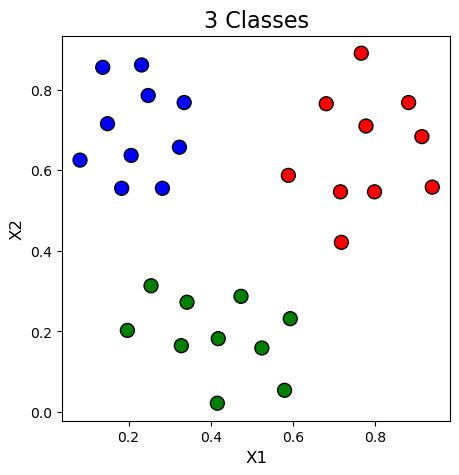

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
data_Class3 = np.loadtxt(readDataPath + '3class_data.csv',delimiter = ',')
df_Class3 = pd.DataFrame({'X1': data_Class3[0],'X2': data_Class3[1], 'Label': data_Class3[2]})
col_3C = np.where(df_Class3['Label']==0,'b',np.where(df_Class3['Label']==1,'r',np.where(df_Class3['Label']==2,'g', 'k')))
ax.scatter(df_Class3['X1'],df_Class3['X2'],c= col_3C, s=100, edgecolors='k')
ax.set_title('3 Classes',fontsize=16)
ax.set_xlabel('X1', fontsize = 12)
ax.set_ylabel('X2', fontsize = 12)
plt.show()

**The goal:**

- We want to learn how to distinguish each class of our data from the other $C-1$ classes.

**One solution:**

- Learn $C$ two-class classifiers on the entire dataset (with the $c^{th}$ classifier trained to distinguish the $c^{th}$ class from the remainder of the data). 

**We need temporary labels:**

- With the $c^{th}$ two-class subproblem we simply assign temporary labels $\tilde y_p$ to the entire dataset, giving $+1$ labels to the $c^{th}$ class and $-1$ labels to the remainder of the dataset

\begin{equation}
\tilde y_p = \begin{cases}   +1 \,\,\,\,\,\,\text{if}\,\, y_p = c \\ -1 \,\,\,\,\,\,\text{if}\,\, y_p \neq c    \end{cases}
\end{equation}

The three places a point in the space can end up (w.r.t our classifiers):

**1. On the positive side of a single classifier**

**2. On the positive side of more than one classifier**

**3. On the negative side of all classifiers**
    

### Points on the positive side of a single classifier

Denoting the weights from the $c^{th}$ classifier as $\mathbf{w}_c$


$$
\mathbf{w}_c=\begin{bmatrix}
w_{0,c}\\
w_{1,c}\\
w_{2,c}\\
\vdots\\
w_{N,c}
\end{bmatrix}
$$

then the corresponding decision boundary can be written as 

\begin{equation}
\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_c = 0.
\end{equation}

Now note how in the figure above how in each case - because each subproblem is perfectly linearly separable and because of our choice of temporary labels - that the class to be distinguished from the rest lies on the *positive side* of its respective classifier, with the remainder of the points lying on the *negative side*.  This of course means that for the $j^{th}$ classifier we have for the $p^{th}$ point $\mathbf{x}_p$ that

\begin{equation}
\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_c  \begin{cases}   > 0 \,\,\,\,\,\,\text{if}\,\,\, y_p = c  \\ < 0 \,\,\,\,\,\, \text{if} \,\,\, y_p \neq c.    \end{cases}
\end{equation}

This implies that - when evaluated by each two-class classifier individually - the one identifying a point's true label always provides the largest evaluation, i.e.,

\begin{equation}
\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_j  = \underset{c \,=\, 0,...,C-1}{\text{max}} \,\,\,\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_c 
\end{equation}

So we know how to classify the points that we have, what about those we do not?  How do we classify arbitrary points in the space of our example?  Lets figure this out step-by-step.  

The points that lie solely on the positive side of the $j^{th}$ classifier only should clearly belong to the $j^{th}$ class.

They clearly satisfy the condition 
\begin{equation}
\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_j = \underset{c \,=\, 0,...,C-1}{\text{max}} \,\,\,\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_c
\end{equation}

Therefore to get the associated label $y$ for these points, we can write
\begin{equation}
y =  \underset{c \,=\, 0,...,C-1}{\text{argmax}} \,\,\,\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_c
\end{equation}

##  Points on the positive side of more than one classifier

Which class should we assign each point to?
- Hint: we can think of a classifier as being 'more confident' of the class identity of given a point, the *farther* the point lies from the classifier's decision boundary (these points are more resistant to perturbations).

How about points equidistant to two or more decision boundaries? 

We assign a class label at random. These points form the **multi-class decision boundary**.

**Classification rule:** in these regions we have assigned each point to the class whose boundary is at the largest nonnegative distance from it. 

How do we compute the distance of an arbitrary point to each of our decision boundaries?

As discussed previously, the *signed distance* of an arbitrary point $\mathbf{x}$ to the $j^{th}$ linear decision boundary is equal to the evaluation at this boundary *provided we normalize its parameters by the magnitude of its feature-touching weights* 

\begin{equation}
\text{signed distance of $\mathbf{x}$ to $j^{th}$ boundary} =  \frac{\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_j }{\left\Vert \boldsymbol{\omega}_{j}^{\,} \right\Vert_2}
\end{equation}

If we *normalize* the weights of each linear classifier by the length of its normal vector as

\begin{equation}
\mathbf{w}_{j}^{\,} \longleftarrow \frac{\mathbf{w}_{j}^{\,}}{\left\Vert \boldsymbol{\omega}_{j}^{\,} \right\Vert_2}
\end{equation}

then this distance is simply written as the raw evaluation of the point via the decision boundary as

\begin{equation}
\text{signed distance of $\mathbf{x}$ to $j^{th}$ boundary} =  \mathring{\mathbf{x}}_{\,}^T \mathbf{w}_j
\end{equation}

Therefore again - after weight-normalization - we have precisely the same prediction rule we found originally for regions of the space where only a single classifier is positive

\begin{equation}
y =  \underset{c \,=\, 0,...,C-1}{\text{argmax}} \,\,\,\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_c.
\end{equation}

## Points on the negative side of all classifiers

As in the previous case, those points equidistant to two or more decision boundaries form the multi-class boundary and are assigned to a relevant class at random.

**Classification rule:** we assign a point to the class whose boundary is at the largest signed distance from it. 

Expressed algebraically, once again we have 

\begin{equation}
y =  \underset{c \,=\, 0,...,C-1}{\text{argmax}} \,\,\,\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_c.
\end{equation}

## Putting it all together

We have now deduced that the single rule for assigning a label $y$ to a point $\mathbf{x}$ 

\begin{equation}
y =  \underset{c \,=\, 0,...,C-1}{\text{argmax}} \,\,\,\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_c.
\end{equation}

which assigns the label based on the maximum signed distance of this point to each classifier, applies to the entire space of our problem (and - in general - to any multi-class problem). In fact this rule not only applies to the toy $C = 3$  dataset we have used in deriving the rule here, but to all multi-class datasets. Indeed we could have used any dataset (even those that are not completely separable) in our derivations here, as any multi-class problem can be broken down into the three fundamental regions we have seen in these derivations: regions where points are on the positive side of a single classifier, more than one classifier, or are on the negative side of all classifiers.

We call this the *fusion rule* - since it tells us precisely how to fuse our $C$ individual classifiers together to make a unified and consistent classification across the entire space of any dataset. It is the core of the *One-versus-All* algorithm, which we now state formally.

We have now deduced that the single rule for assigning a label $y$ to a point $\mathbf{x}$ 

\begin{equation}
y =  \underset{c \,=\, 0,...,C-1}{\text{argmax}} \,\,\,\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_c.
\end{equation}

which assigns the label based on the maximum signed distance of this point to each classifier, applies to the entire space of our problem. 

We call this the **fusion rule** since it tells us precisely how to fuse our $C$ individual classifiers together to make a unified and consistent classification across the entire space of any dataset.

### One-versus-All  multi-class classification

1. Input: multiclass dataset $\left\{ \left(\mathbf{x}_{p,}\,y_{p}\right)\right\} _{p=1}^{P}$ where $y_{p}\in\left\{ 0,...,C-1\right\}$, two-class classification scheme and optimizer <br>
2. <code>for</code> $\,\,j \, = \, 0,...,C-1$<br>
    * form temporary labels $\tilde y_p = \begin{cases}   +1 \,\,\,\,\,\,\text{if}\,\, y_p = j \\ -1 \,\,\,\,\,\,\text{if}\,\, y_p \neq j    \end{cases}$ <br>
    * solve two-class subproblem on $\left\{ \left(\mathbf{x}_{p,}\,\tilde y_{p}\right)\right\} _{p=1}^{P}$ to find weights $\mathbf{w}_j$
<br>
    * normalize classifier weights by magnitude of feature-touching portion $\mathbf{w}_{j}^{\,} \longleftarrow \frac{\mathbf{w}_{j}^{\,} }{\left\Vert \boldsymbol{\omega}_{j}^{\,} \right\Vert_2}$ 
<br>
3. <code>end for</code> <br>
4. To assign label $y$ to a point $\mathbf{x}$, apply the fusion rule: $y =  \underset{c\,=\, 0,...,C-1}{\text{argmax}} \,\,\,\mathring{\mathbf{x}}_{\,}^T \mathbf{w}_c$<br>
<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

**Note:** In practice it is common to see implementations that skip the normalization step. This can theoretically lead to poor classification due to different sized normal vectors creating out of scale distance-to-classifier measurements. However because often each classifier is trained using the same optimization framework (e.g., the same sized initialization and optimization algorithm) the resulting size of each trained normal vector can end up being around the same size (hence reducing the need for normalization).

## Implementation

To take advantage of the `numpy` libraries fast array operations we use the notation first introduced in, we stack the trained weights from our $C$ classifiers together into a single $\left(N + 1\right) \times C$ array of the form

$$
\mathbf{W}=\begin{bmatrix} 
w_{0,0}  &  w_{0,1}  &  w_{0,2}  & \cdots   &  w_{0,C-1}  \\
w_{1,0}  &  w_{1,1}  &  w_{1,2}  & \cdots  &   w_{1,C-1}  \\
w_{2,0}  &  w_{2,1}  &  w_{2,2}  & \cdots  &  w_{2,C-1}  \\
\,\,\, {\vdots}_{\,\,\,}  & {\vdots}_{\,\,\,}  &  {\vdots}_{\,\,\,}  &  \cdots   &    {\vdots}_{\,\,\,}    \\
w_{N,0}  &  w_{N,1} & w_{N,2}  &  \cdots  &  w_{N,C-1}  \\
\end{bmatrix}
$$

We also extend our `model` notation to denote the evaluation of our $C$ individual linear models as


\begin{equation}
\begin{matrix} 
\text{model}\left(\mathbf{x},\mathbf{W}\right) = \mathring{\mathbf{x}}_{\,}^T\mathbf{W} \end{matrix}  = \begin{bmatrix}
\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{0}^{\,}   &
\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{1}^{\,}   &
\cdots \, &
\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{C-1}^{\,}
\end{bmatrix}
\end{equation}

Notice that we can now write the fusion rule in this extended `model` notation equivalently as 

\begin{equation}
y = \underset{c \,=\, 0,...,C-1} {\text{max}}\,\text{model}\left(\mathbf{x},\mathbf{W}\right).
\end{equation}

#### <span style="color:#a50e3e;">Example. </span> Classifying a dataset with $C = 3$ classes using OvA

In [17]:
data_Class3 = np.loadtxt(readDataPath + '3class_data.csv',delimiter = ',')
x = data_Class3[:-1]
minx = min(min(x[0,:]),min(x[1,:]))
maxx = max(max(x[0,:]),max(x[1,:]))
y_labels = copy.deepcopy(data_Class3[-1])
num_classes = np.size(np.unique(y_labels))
print("number of classes: ", num_classes)

number of classes:  3


In [18]:
import autograd.numpy as np

In [19]:
max_its_set = 10; epsilon_choice = 10**(-7)

In [20]:
#np.random.seed(10)
max_its_set = 5; epsilon_choice = 10**(-5)
#shape of w should be [w0, w1, w2] since this is a line
weight_histories = []
for c in range(0,num_classes):
    y_temp = copy.deepcopy(y_labels)
    ind = np.argwhere(y_temp == (c))
    ind = ind[:,0]
    ind2 = np.argwhere(y_temp != (c))
    ind2 = ind2[:,0]
    y_temp[ind] = 1
    y_temp[ind2] = -1
    
    epsilon = epsilon_choice
    max_its = max_its_set;
    w = np.random.randn(x.shape[0]+1,1);
    #run gradient descent and Newton's method and solve the current subproblem
    cost = softmax;
    weight_history = 0; cost_history = 0;
    weight_history = newtons_method(cost,max_its,w, epsilon, x, y_temp)
    #weight_histories.append(copy.deepcopy(weight_history)) #length of list equal to #classes, each item has length max_its+1
    
    
    g_count = []
    for j in range(len(weight_history)):
        weight = weight_history[j]
        gval = cost(weight,x,y_temp)
        g_count.append(gval)
    ind = np.argmin(g_count)
    weight = weight_history[ind]
    # normalize normal vectors for each classifier
    w_norm = sum([v**2 for v in weight[1:]])**(0.5)
    w_1N = [v/w_norm for v in weight]
    weight_histories.append(w_1N)
    
weight_histories = np.array(weight_histories)
weight_histories.shape = (num_classes, np.shape(x)[0] + 1)

In [21]:
last_weights = weight_histories

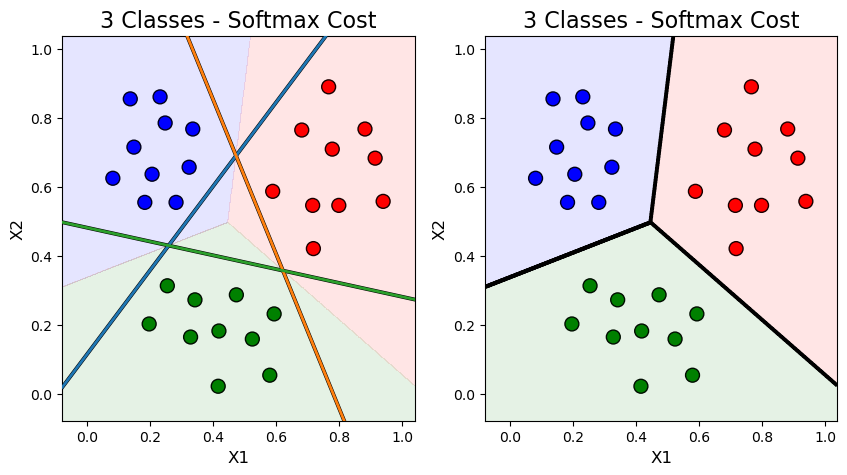

In [22]:
plot_OVA(minx, maxx, last_weights, df_Class3, col_3C, num_classes, title = '3 Classes - Softmax Cost')

#### <span style="color:#a50e3e;">Example. </span> Classifying a dataset with $C = 4$ classes using OvA

In this example we quickly apply the OvA algorithm derived above to a toy dataset with $C=4$ classes shown below.

In [23]:
data_Class4 = np.loadtxt(readDataPath + '4class_data.csv',delimiter = ',')
df_Class4  = pd.DataFrame({'X1': data_Class4[0],'X2': data_Class4[1], 'Label': data_Class4[2]})

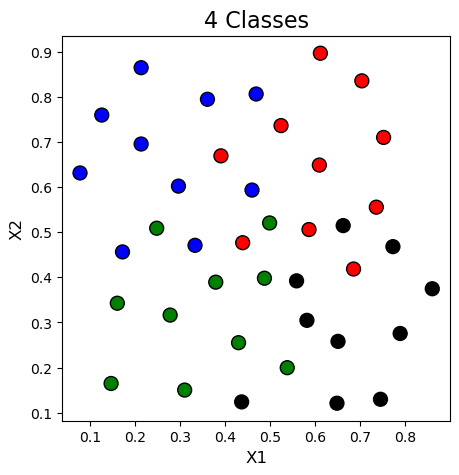

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
col_4C = np.where(df_Class4['Label']==0,'b',np.where(df_Class4['Label']==1,'r',np.where(df_Class4['Label']==2,'g', 'k')))
ax.scatter(df_Class4['X1'],df_Class4['X2'],c= col_4C, s=100, edgecolors='k')
ax.set_title('4 Classes', fontsize=16)
ax.set_xlabel('X1', fontsize = 12)
ax.set_ylabel('X2', fontsize = 12)
plt.show()

In [25]:
x = data_Class4[:-1]
minx = min(min(x[0,:]),min(x[1,:]))
maxx = max(max(x[0,:]),max(x[1,:]))
y_labels = copy.deepcopy(data_Class4[-1])
num_classes = np.size(np.unique(y_labels))
print("number of classes: ", num_classes)

number of classes:  4


In [26]:
#np.random.seed(10)
max_its_set = 5; epsilon_choice = 10**(-5)
#shape of w should be [w0, w1, w2] since this is a line
weight_histories = []
for c in range(0,num_classes):
    y_temp = copy.deepcopy(y_labels)
    ind = np.argwhere(y_temp == (c))
    ind = ind[:,0]
    ind2 = np.argwhere(y_temp != (c))
    ind2 = ind2[:,0]
    y_temp[ind] = 1
    y_temp[ind2] = -1
    
    epsilon = epsilon_choice
    max_its = max_its_set;
    w = np.random.randn(x.shape[0]+1,1);
    #run gradient descent and Newton's method and solve the current subproblem
    cost = softmax;
    weight_history = 0; cost_history = 0;
    weight_history = newtons_method(cost,max_its,w, epsilon, x, y_temp)
    #weight_histories.append(copy.deepcopy(weight_history)) #length of list equal to #classes, each item has length max_its+1
    
    
    g_count = []
    for j in range(len(weight_history)):
        weight = weight_history[j]
        gval = cost(weight,x,y_temp)
        g_count.append(gval)
    ind = np.argmin(g_count)
    weight = weight_history[ind]
    # normalize normal vectors for each classifier
    w_norm = sum([v**2 for v in weight[1:]])**(0.5)
    w_1N = [v/w_norm for v in weight]
    weight_histories.append(w_1N)
    
weight_histories = np.array(weight_histories)
weight_histories.shape = (num_classes, np.shape(x)[0] + 1)



In [27]:
last_weights = weight_histories

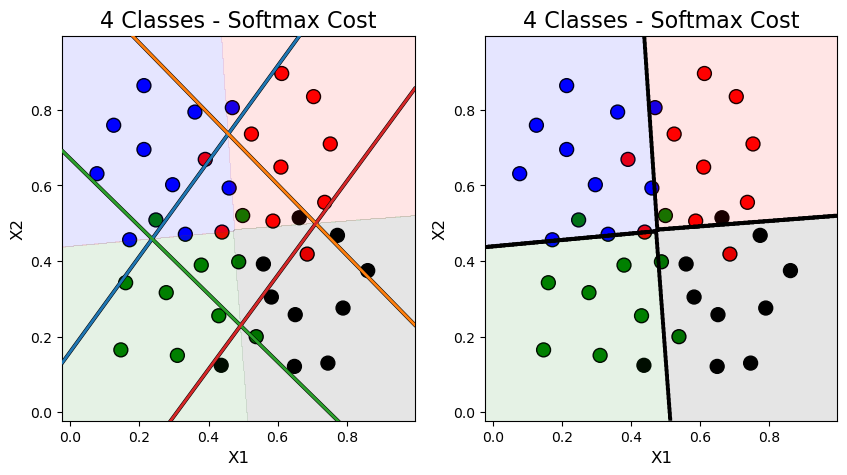

In [28]:
plot_OVA(minx, maxx, last_weights, df_Class4, col_4C, num_classes, title = '4 Classes - Softmax Cost')

# Multi-Class Classification and the Perceptron

In this Section we discuss a natural alternative to OvA multi-class classification detailed in the previous Section.   Instead of training $C$ two class classifiers *first* and *then* fusing them into a single decision boundary (via the *fusion rule*), we can train all $C$ classifiers *simultaneously* to explicitly satisfy the fusion rule directly.  In particular here we derive the *Multi-class Perceptron* cost for achieving this feat, which can be thought of as a direct generalization of the two class perceptron.

Once again we deal with an arbitrary multi-class dataset $\left\{ \left(\mathbf{x}_{p,}\,y_{p}\right)\right\} _{p=1}^{P}$ consisting of $C$ distinct classes of data.

The labels for these classes can be made arbitrarily, but here we will once again employ label values $y_{p}\in\left\{ 0,1,...,C-1\right\} $.  

Recall the fusion rule

\begin{equation}
y_p =   \underset{c \,=\, 0,...,C-1}{\text{argmax}} \,\,\,\mathring{\mathbf{x}}_{p}^T \mathbf{w}_c^{\,}.
\end{equation}

Our aim is (instead of tuning our each classifier's weights one-by-one and then combining them) to **learn all sets of weights simultaneously so as to satisfy this ideal condition as often as possible**.

To get started in constructing a proper cost function by which our ideal weights can be determined upon proper minimization, first note that for the *if* the above is to hold for our $p^{th}$ point then we can likewise say that the following is true as well

\begin{equation}
\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,} = \underset{c \,=\, 0,...,C-1}{\text{max}} \,\,\,\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}.
\end{equation}

Remember geometrically this simply says that the (signed) distance from the point $\mathbf{x}_p$ to its class decision boundary is greater than its distance from every other class's. This is what we want for all of our training datapoints - to have the prediction provided by the fusion rule match our given labels, and hence the above to be true for every point $\mathbf{x}_p$.

Let's slightly re-write the fusion rule:

\begin{equation}
\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,} = \underset{c \,=\, 0,...,C-1}{\text{max}} \,\,\,\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}.
\end{equation}

This means that their difference - subtracting $\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}$ from both sides - gives a pointwise cost that is *always nonnegative* and minimal at zero

\begin{equation}
g_p\left(\mathbf{w}_0,...,\mathbf{w}_{C-1}\right) = \left(\underset{c \,=\, 0,...,C-1}{\text{max}} \,\,\,\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}\right) - \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}.
\end{equation}

If our weights are set ideally this value should be zero for as many points as possible - i.e., so that the weights $\mathbf{w}_{y_p}^{\,}$ have been tuned correctly so that indeed the $y_p^{th}$ classifier provides the largest evaluation of $\mathbf{x}_p$. With this in mind, we can then easily form a cost function by taking the *average* of the pointwise cost above as $\frac{1}{P}\sum_{p = 1}^P g_p$ or equivalently 

\begin{equation}
g\left(\mathbf{w}_{0}^{\,},\,...,\mathbf{w}_{C-1}^{\,}\right) = \frac{1}{P}\sum_{p = 1}^P \left[ \left(\underset{c \,=\, 0,...,C-1}{\text{max}} \,\,\,\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}\right) - \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}\right]
\end{equation}

This *multi-class Perceptron* cost function is nonnegative and - when weights are tuned correctly - is as small as possible.  Thus we can stop *assuming* that we have ideal weights, and minimize this cost in order to find them.  Note here that unlike the OvA, here we tune all weights *simultaneously* in order to recover weights that satisfy the fusion rule as well as possible.  Like its two class analog, the multi-class Perceptron is also *convex* regardless of the dataset employed.  It also has a *trivial solution at zero*, that is when $\mathbf{w}_c = \mathbf{0}$ for all $c$ the cost is minimal which is to be avoided (which is often achievable by initializing any local optimization scheme used to minimize it away from the origin). 

Taking the *average* of this point-wise cost over the entire dataset we have

\begin{equation}
g\left(\mathbf{w}_{0}^{\,},\,...,\mathbf{w}_{C-1}^{\,}\right) = \frac{1}{P}\sum_{p = 1}^P \left[ \left(\underset{c \,=\, 0,...,C-1}{\text{max}} \,\,\,\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}\right) - \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}\right]
\end{equation}

gives us the **multi-class Perceptron** cost function, which like its two class analog.


- is **convex**
- has a **trivial solution at zero** (which is often avoided by initializing local optimization away from the origin). 

The *multi-class Perceptron cost* is a direct generalization of its two-class version previously introduced.


Hint: write the multi-class Perceptron cost in the following equivalent form 

\begin{equation}
g\left(\mathbf{w}_{0}^{\,},\,...,\mathbf{w}_{C-1}^{\,}\right) = \frac{1}{P}\sum_{p = 1}^P \underset{ \underset{c \neq y_p }{ c \,=\, 0,...,C-1}  }{\text{max}} \left(0,\mathring{\mathbf{x}}_{p}^T\left( \overset{\,}{\mathbf{w}}_c^{\,} - \overset{\,}{\mathbf{w}}_{y_p}^{\,}\right)\right).
\end{equation}

Here we can see that the corresponding pointwise cost $g_p\left(\mathbf{w}_0,...,\mathbf{w}_{C-1}\right) = \underset{ \underset{c \neq y_p }{ c \,=\, 0,...,C-1}  }{\text{max}} \left(0,\mathring{\mathbf{x}}_{p}^T\left( \overset{\,}{\mathbf{w}}_c^{\,} - \overset{\,}{\mathbf{w}}_{y_p}^{\,}\right)\right)$ now mirrors its the two class analog.  In this form it is straightforward to then show that when $C = 2$ the multi-class Perceptron reduces to the two class version.

Recall that in order to fairly compare the distance of each input $\mathbf{x}_p$ to our two-class decision boundaries, we should formally subject the cost to the constraints that all normal vectors have unit length.

Separating the biases from feature-touching weights, this leads to the following constrained problem


$$
\begin{aligned}
\underset{b_{0}^{\,},\,\boldsymbol{\omega}_{0}^{\,},\,...,\,b_{C-1}^{\,},\,\boldsymbol{\omega}_{C-1}^{\,}}{\text{argmin}\,\,\,} &  \frac{1}{P}\sum_{p = 1}^P \left[\left(\underset{c \,=\, 0,...,C-1}{\text{max}} b_{c}^{\,} + \mathbf{x}_{p}^T\boldsymbol{\omega}_{c}^{\,}\right) - \left(b_{y_p}^{\,} + \mathbf{x}_{p}^T\boldsymbol{\omega}_{y_p}^{\,}\right)\right]\\
\text{subject to}\,\,\, & \,\,\,\,\, \left \Vert \boldsymbol{\omega}_{c}^{\,} \right \Vert_2^2  = 1, \,\,\,\,\,\, c \,=\, 0,...,C-1
\end{aligned}
$$

Although we can solve this problem directly (e.g., by using projected gradient descent), it is more commonplace to approximately solve it by *relaxing the constraints*.

\begin{equation}
\frac{1}{P}\sum_{p = 1}^P \left[\left(\underset{c \,=\, 0,...,C-1}{\text{max}} \,\,\,b_{c}^{\,} + \mathbf{x}_{p}^T\boldsymbol{\omega}_{c}^{\,}\right) - \left(b_{y_p}^{\,} + \mathbf{x}_{p}^T\boldsymbol{\omega}_{y_p}^{\,}\right)\right]+ \lambda \sum_{c = 0}^{C-1} \left \Vert \boldsymbol{\omega}_{c}^{\,} \right \Vert_2^2 
\end{equation}

For simplicity we choose a single regularization parameter $\lambda \geq 0$ that is used to penalize the magnitude of all normal vectors simultaneously.

This regularized form does not quite match the original constrained formulation as regularizing all normal vectors together will not necessarily guarantee that $\left \Vert \boldsymbol{\omega}_{c}^{\,} \right \Vert_2^2 = 1$ for all $c$.  However it will generally force the length of all normal vectors to behave well, e.g., disallowing one normal vector to grow arbitrarily large while one shrinks to almost nothing. As we see many times in machine learning, it is commonplace to make such compromises to get something that is 'close enough' to the original as long as it does work well in practice. This is indeed the case here with $\lambda$ typically set to a small value (e.g., $10^{-3}$ and smaller).

## Implementing and minimizing a modular multi-class Perceptron in `Python`

We extend our `model` notation to denote the evaluation of our $C$ individual linear models as


\begin{equation}
\begin{matrix} 
\text{model}\left(\mathbf{x},\mathbf{W}\right) = \mathring{\mathbf{x}}_{\,}^T\mathbf{W} \end{matrix}  = \begin{bmatrix}
\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{0}^{\,}   &
\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{1}^{\,}   &
\cdots \, &
\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{C-1}^{\,}
\end{bmatrix}
\end{equation}

With this `model` notation we can more conveniently implement essentially any formula derived from the fusion rule like e.g., the multi-class Perceptron.  For example, we can write the fusion rule itself equivalently as 

\begin{equation}
y = \underset{c \,=\, 0,...,C-1} {\text{max}}\,\text{model}\left(\mathbf{x},\mathbf{W}\right).
\end{equation}

Likewise we can write the $p^{th}$ summand of the multi-class Perceptron compactly as


\begin{equation}
\left(\underset{c \,=\, 0,...,C-1}{\text{max}} \,\,\,\mathring{\mathbf{x}}_{p}^T \mathbf{w}_c^{\,}\right) - \mathring{\mathbf{x}}_{p}^T \mathbf{w}_{y_p}^{\,}. = \left(\underset{c \,=\, 0,...,C-1} {\text{max}}\,\text{model}\left(\mathbf{x}_p,\mathbf{W}\right)\right) - \text{model}\left(\mathbf{x}_p,\mathbf{W}\right)_{y_p}.
\end{equation}

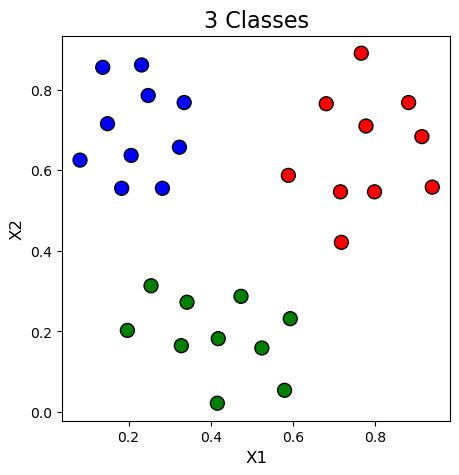

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
data_Class3 = np.loadtxt(readDataPath + '3class_data.csv',delimiter = ',')
df_Class3 = pd.DataFrame({'X1': data_Class3[0],'X2': data_Class3[1], 'Label': data_Class3[2]})
col_3C = np.where(df_Class3['Label']==0,'b',np.where(df_Class3['Label']==1,'r',np.where(df_Class3['Label']==2,'g', 'k')))
ax.scatter(df_Class3['X1'],df_Class3['X2'],c= col_3C, s=100, edgecolors='k')
ax.set_title('3 Classes',fontsize=16)
ax.set_xlabel('X1', fontsize = 12)
ax.set_ylabel('X2', fontsize = 12)
plt.show()

In [30]:
x = data_Class3[:-1,:]
y = data_Class3[-1:,:]

In [31]:
minx = min(min(x[0,:]),min(x[1,:]))
maxx = max(max(x[0,:]),max(x[1,:]))
y_labels = copy.deepcopy(y)
num_classes = np.size(np.unique(y_labels))
print("number of classes: ", num_classes)

number of classes:  3


In [32]:
np.random.seed(0)
g = multiclass_perceptron; w = 0.1*np.random.randn(np.shape(x)[0]+1,num_classes); max_its = 1000; alpha_choice = 10**(-1);
weight_history,cost_history = gradient_descent(g,alpha_choice,max_its,w, data = x, labels = y, inputs_flag=True) #cannot use Newton's Method since the second derivative of perceptron cost is zero

In [33]:
last_weights = weight_history[-1]

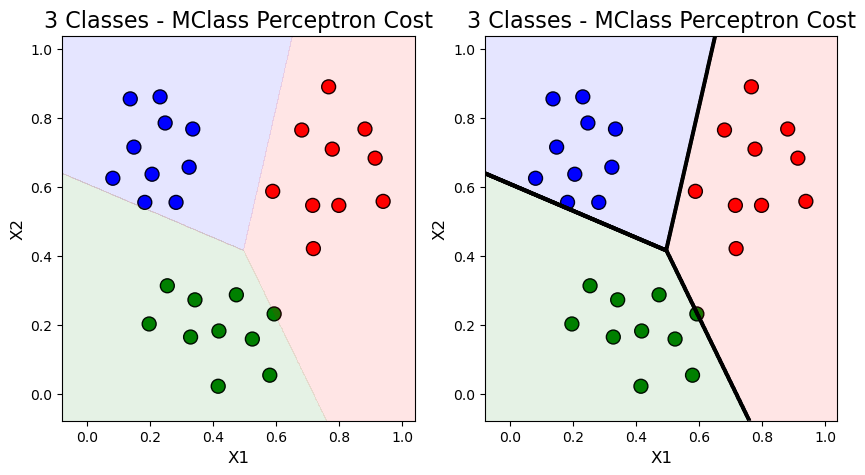

In [34]:
plot_multi_class(minx, maxx, last_weights, df_Class3, col_3C, num_classes, title = '3 Classes - MClass Perceptron Cost')

##  The Multi-class Softmax / Cross Entropy cost function

As we saw previously with the case of the two class perceptron, we are often willing to sacrifice a small amount of modeling precision - forming a closely matching smoother cost function to the one we already have - in order to make optimization easier or expand the optimization tools we can bring to bear.  

As was the case with the two-class perceptron, here too we can *smooth* the multi-class Perceptron cost employing the **softmax** function, defined as

\begin{equation}
\text{soft}\left(s_0,s_1,...,s_{C-1}\right) = \text{log}\left(e^{s_0} + e^{s_1} + \cdots + e^{s_{C-1}} \right)
\end{equation}

which is a close and smooth approximation to the **max** function

\begin{equation}
\text{soft}\left(s_0,s_1,...,s_{C-1}\right) \approx \text{max}\left(s_0,s_1,...,s_{C-1}\right).
\end{equation}

Replacing the $\text{max}$ function in each summand of the multi-class Perceptron gives

\begin{equation}
g\left(\mathbf{w}_{0}^{\,},\,...,\mathbf{w}_{C-1}^{\,}\right) = \frac{1}{P}\sum_{p = 1}^P \left[\text{log}\left( \sum_{c = 0}^{C-1}  e^{ \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}}  \right) - \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}\right].
\end{equation}

This is referred to as the **multi-class Softmax** cost function, which

- is convex
- unlike the Multiclass Perceptron has infinitely many smooth derivatives 
- no longer has a trivial solution at zero

**Why multi-class Softmax?**

Because it is a softmax-smoothed version of the Multiclass Perceptron and because it is the natural generalization of the two-class version.
Hint: replace the $\text{max}$ with the $\text{softmax}$ approximation to form

\begin{equation}
g\left(\mathbf{w}_{0}^{\,},\,...,\mathbf{w}_{C-1}^{\,}\right) = \frac{1}{P}\sum_{p = 1}^P  \text{log}\left(1 + \sum_{\underset{j \neq y_p}{c = 0}}^{C-1}  e^{ \mathring{\mathbf{x}}_{p}^T \left(\overset{\,}{\mathbf{w}}_c^{\,} - \overset{\,}{\mathbf{w}}_{y_p}^{\,}\right)}  \right).
\end{equation}

**Why multi-class Cross Entropy?**

Because - likewise - it is a natural generalization of the two class-version.
Hint: write it - after some algebraic manipulation - as  


\begin{equation}
g\left(\mathbf{w}_{0}^{\,},\,...,\mathbf{w}_{C-1}^{\,}\right) = -\frac{1}{P}\sum_{p = 1}^P  \text{log}\left( \frac{e^{\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}}}  {\sum_{c = 0}^{C-1}  e^{ \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}} }    \right) .
\end{equation}

Now we can use the $\text{log}$ property that 

\begin{equation}
 \text{log}\left(s\right) - \text{log}\left(t\right) = \text{log}\left(\frac{s}{t}\right) 
\end{equation}

to rewrite the above as 

\begin{equation}
\text{log}\left( \sum_{c = 0}^{C-1}  e^{ \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}}  \right) - \text{log}\,e^{\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}} = \text{log}\left( \frac{\sum_{c = 0}^{C-1}  e^{ \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}}}  {e^{\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}}}    \right).
\end{equation}

Finally because by the $\text{log}$ property that

\begin{equation}
\text{log}\left(s\right) = -\text{log}\left(\frac{1}{s}\right)
\end{equation}

this can be rewritten equivalently as 

\begin{equation}
\text{log}\left( \frac{ \sum_{c = 0}^{C-1}  e^{ \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}}}  {e^{\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}}}    \right) = -\text{log}\left( \frac{e^{\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}}}  {\sum_{c = 0}^{C-1}  e^{ \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}} }    \right) 
\end{equation}

So in sum, we can rewrite 

\begin{equation}
g\left(\mathbf{w}_{0}^{\,},\,...,\mathbf{w}_{C-1}^{\,}\right) = -\frac{1}{P}\sum_{p = 1}^P  \text{log}\left( \frac{e^{\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}}}  {\sum_{c = 0}^{C-1}  e^{ \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}} }    \right) .
\end{equation}

Visually this appears more similar to the two class Cross Entropy cost, and indeed does reduce to it in quite a straightforward manner when $C = 2$ (and $y_p \in \left\{0,1\right\}$ are chosen).

###  Regularization and the multi-class Softmax

As with the multi-class Percpetron, it is common to *regularize* the Multiclass Softmax via its feature touching weights as 

\begin{equation}
\frac{1}{P}\sum_{p = 1}^P \left[\text{log}\left( \sum_{c = 0}^{C-1}  e^{ b_{c}^{\,} + \mathbf{x}_{p}^T\boldsymbol{\omega}_{c}^{\,} }  \right) - \left(b_{y_p}^{\,} + \mathbf{x}_{p}^T\boldsymbol{\omega}_{y_p}^{\,}\right)\right] + \lambda \sum_{c = 0}^{C-1} \left \Vert \boldsymbol{\omega}_{c}^{\,} \right \Vert_2^2 
\end{equation}

where $\lambda \geq 0$ is typically set to a small value like e.g., $10^{-3}$.  In addition to this being more formally appropriate - given that our cost funtions originate with the fusion rule established in the previous Section - this can also be interpreted as a way of preventing local optimization methods like Newton's method (which take large steps) from diverging when dealing with perfectly seperable data.

### Implementing and minimizing a modular multi-class softmax in `Python`

We can implement the multi-class Softmax cost very similar to how the Multiclass Perceptron was implemented above.  That is, using the compact model notation introduced there

\begin{equation}
\begin{matrix} 
\text{model}\left(\mathbf{x},\mathbf{W}\right) = \mathring{\mathbf{x}}_{\,}^T\mathbf{W} \end{matrix}  = \begin{bmatrix}
\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{0}^{\,}   &
\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{1}^{\,}   &
\cdots \, &
\mathring{\mathbf{x}}_{\,}^T  \overset{\,}{\mathbf{w}}_{C-1}^{\,}
\end{bmatrix}
\end{equation}

Likewise we can write the $p^{th}$ summand of the multi-class Softmax (as written in equation (16)) compactly as

\begin{equation}
\left(\underset{c \,=\, 0,...,C-1}{\text{softmax}} \,\,\,\mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}\right) - \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}. = \left(\underset{c \,=\, 0,...,C-1} {\text{softmax}}\,\text{model}\left(\mathbf{x}_p,\mathbf{W}\right)\right) - \text{model}\left(\mathbf{x}_p,\mathbf{W}\right)_{y_p}.
\end{equation}

#### <span style="color:#a50e3e;">Example. </span> Multi-class Softmax on a toy dataset with $C=3$ classes using Gradient Descent

In [35]:
x = data_Class3[:-1,:]
y = data_Class3[-1:,:]

minx = min(min(x[0,:]),min(x[1,:]))
maxx = max(max(x[0,:]),max(x[1,:]))
y_labels = copy.deepcopy(y)
num_classes = np.size(np.unique(y_labels))
print("number of classes: ", num_classes)

number of classes:  3


In [36]:
np.random.seed(0)
g = multiclass_softmax; w = 0.1*np.random.randn(np.shape(x)[0]+1,num_classes); max_its = 200; alpha_choice = 1;
weight_history,cost_history = gradient_descent(g,alpha_choice,max_its,w, data = x, labels = y, inputs_flag=True)

In [37]:
last_weights = weight_history[-1]

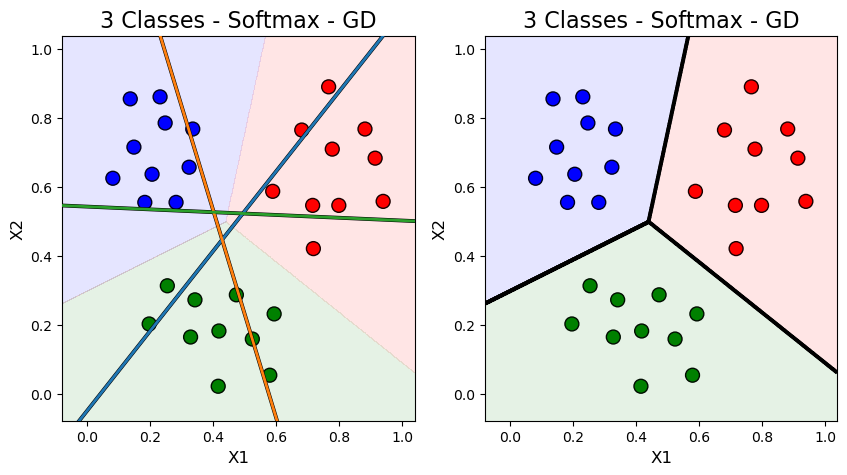

In [38]:
plot_multi_class(minx, maxx, last_weights, df_Class3, col_3C, num_classes, title = '3 Classes - Softmax - GD')

#### <span style="color:#a50e3e;">Example. </span> Multi-class Softmax on a toy dataset with $C=3$ classes using Newton's Method

In [39]:
np.random.seed(0)
g = multiclass_softmax; w = 0.1*np.random.randn(np.shape(x)[0]+1,num_classes); max_its = 5; alpha_choice = 1;
epsilon_choice = 10**-7
weight_history = newtons_method(g,max_its,w, epsilon_choice, x, y)

In [40]:
last_weights = weight_history[-1]

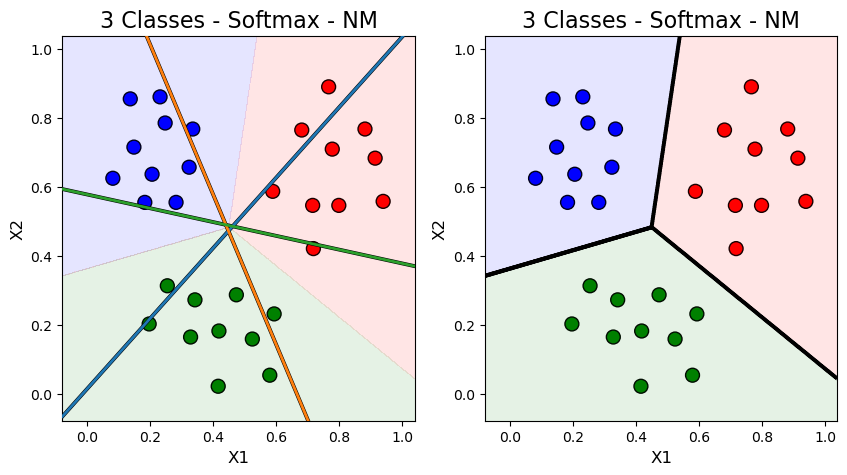

In [41]:
plot_multi_class(minx, maxx, last_weights, df_Class3, col_3C, num_classes, title = '3 Classes - Softmax - NM')

#### <span style="color:#a50e3e;">Example. </span> Multi-class Softmax on a toy dataset with $C = 4$ classes

In [42]:
x = data_Class4[:-1]
minx = min(min(x[0,:]),min(x[1,:]))
maxx = max(max(x[0,:]),max(x[1,:]))
y_labels = copy.deepcopy(data_Class4[-1])
num_classes = np.size(np.unique(y_labels))
print("number of classes: ", num_classes)

number of classes:  4


In [43]:
np.random.seed(0)
g = multiclass_softmax; w = 0.1*np.random.randn(np.shape(x)[0]+1,num_classes); max_its = 5; epsilon_choice = 10**-7
weight_history = newtons_method(g,max_its,w, epsilon_choice, x, y_labels)

In [44]:
last_weights = weight_history[-1]

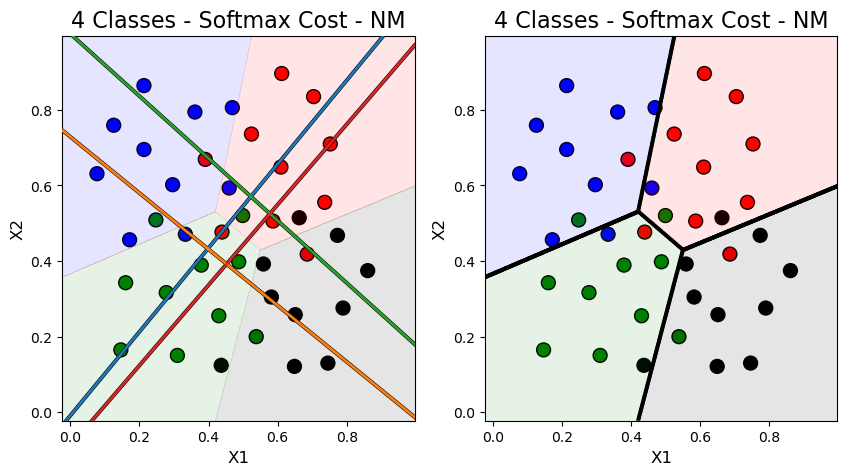

In [45]:
plot_multi_class(minx, maxx, last_weights, df_Class4, col_4C, num_classes, title = '4 Classes - Softmax Cost - NM')

## Comparison

- We illustrate this principal superiority of the Multi-class Perceptron / Softmax approach over OvA using a toy $C = 5$ class dataset shown below.  
- Here points colred red, blue, green, kahki, and violet have label values $y_p = 0$, $1$, $2$, $3$, and $4$ respectively. 

In [46]:
data = np.loadtxt(readDataPath + '5class_data.csv',delimiter = ',')

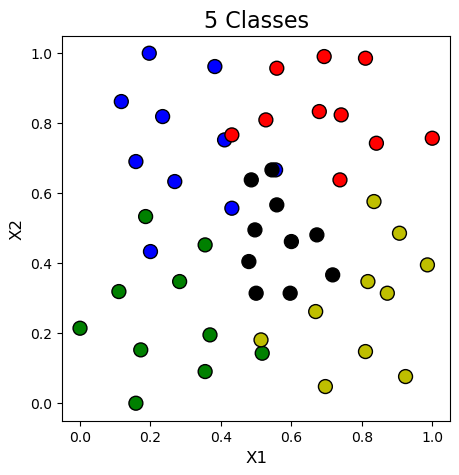

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
data_Class5 = np.loadtxt(readDataPath + '5class_data.csv',delimiter = ',')
df_Class5 = pd.DataFrame({'X1': data_Class5[0],'X2': data_Class5[1], 'Label': data_Class5[2]})
col_5C = np.where(df_Class5['Label']==0,'b',np.where(df_Class5['Label']==1,'r',np.where(df_Class5['Label']==2,'g', np.where(df_Class5['Label']==3, 'k', 'y'))))
ax.scatter(df_Class5['X1'],df_Class5['X2'],c= col_5C, s=100, edgecolors='k')
ax.set_title('5 Classes',fontsize=16)
ax.set_xlabel('X1', fontsize = 12)
ax.set_ylabel('X2', fontsize = 12)
plt.show()

In [48]:
x = data_Class5[:-1]
minx = min(min(x[0,:]),min(x[1,:]))
maxx = max(max(x[0,:]),max(x[1,:]))
y_labels = copy.deepcopy(data_Class5[-1])
num_classes = np.size(np.unique(y_labels))
print("number of classes: ", num_classes)

number of classes:  5


In [49]:
data_Class5.shape

(3, 50)

In [50]:
#np.random.seed(0)
max_its_set = 5; epsilon_choice = 10**(-5)

In [51]:
#np.random.seed(10)
max_its_set = 5; epsilon_choice = 10**(-5)
#shape of w should be [w0, w1, w2] since this is a line
weight_histories = []
for c in range(0,num_classes):
    y_temp = copy.deepcopy(y_labels)
    ind = np.argwhere(y_temp == (c))
    ind = ind[:,0]
    ind2 = np.argwhere(y_temp != (c))
    ind2 = ind2[:,0]
    y_temp[ind] = 1
    y_temp[ind2] = -1
    
    epsilon = epsilon_choice
    max_its = max_its_set;
    w = np.random.randn(np.shape(x)[0]+1,1);
    #run gradient descent and Newton's method and solve the current subproblem
    cost = softmax;
    weight_history = 0; cost_history = 0;
    weight_history = newtons_method(cost,max_its,w, epsilon, x, y_temp)
    #weight_histories.append(copy.deepcopy(weight_history)) #length of list equal to #classes, each item has length max_its+1
    
    
    g_count = []
    for j in range(len(weight_history)):
        weight = weight_history[j]
        gval = cost(weight,x,y_temp)
        g_count.append(gval)
    ind = np.argmin(g_count)
    weight = weight_history[ind]
    # normalize normal vectors for each classifier
    w_norm = sum([v**2 for v in weight[1:]])**(0.5)
    w_1N = [v/w_norm for v in weight]
    weight_histories.append(w_1N)
    
weight_histories = np.array(weight_histories)
weight_histories.shape = (num_classes, np.shape(x.T)[1] + 1)

In [52]:
last_weights = weight_histories

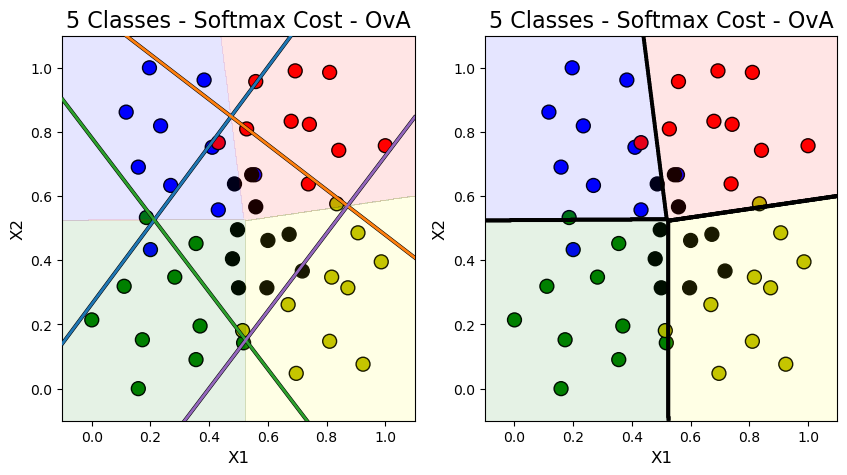

In [53]:
plot_OVA(minx, maxx, last_weights, df_Class5, col_5C, num_classes, title = '5 Classes - Softmax Cost - OvA')

In [54]:
g = multiclass_softmax; w = 0.1*np.random.randn(3,num_classes); max_its = 5; epsilon_choice = 10**-7
weight_history = newtons_method(g,max_its,w, epsilon_choice, x, y_labels)

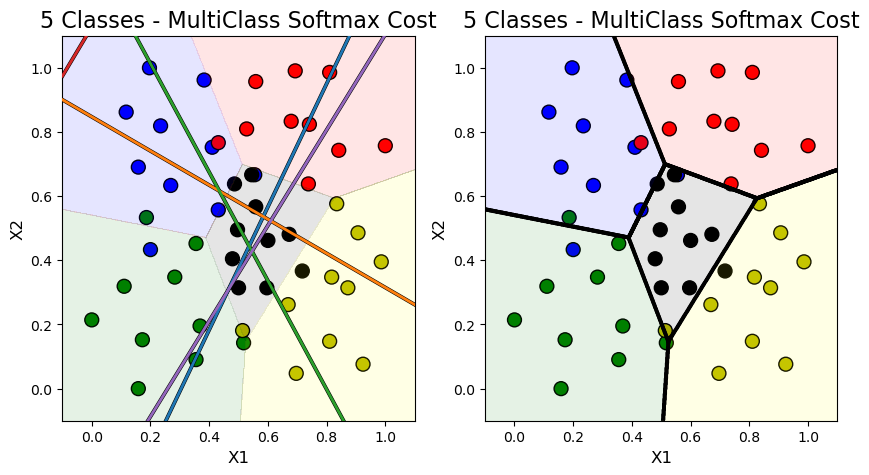

In [55]:
last_weights = weight_history[-1]
plot_multi_class(minx, maxx, last_weights, df_Class5, col_5C, num_classes, title = '5 Classes - MultiClass Softmax Cost')

### Classification Quality Metrics

### Making predictions using a trained model

- Assume the default label values $y_p \in \left\{0,1,...,C-1\right\}$.


- We denote the optimal set of weights found by minimizing a classification cost function (or via performing OvA) by $\mathbf{W}^{\star}$.


- Then note we can write our fully tuned linear model as 

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{W}^{\star}\right) =  \mathring{\mathbf{x}}_{\,}^T\mathbf{W}^{\star}   
\end{equation}

- This fully trained model defines an optimal decision boundary for the training dataseet which is defined by the fusion rule
\begin{equation}
\underset{c=0,...,C-1}{\text{argmax}}\,\, \mathbf{x}^T \mathbf{w}_c^{\star}.
\end{equation}

- To predict the label $y$ of an input $\mathbf{x}$ we then process it through this rule as
\begin{equation}
y_{\,} = \underset{c=0,...,C-1}{\text{argmax}}\,\, \mathbf{x}^T \mathbf{w}_c^{\star} 
\end{equation}

- Here any point lying *exactly* on the decision boundary should be assigned a label randomly based on the index of those classifiers providing maximum evaluation.

###  Judging the quality of a trained model using *accuracy*

- To *count the number of misclassifications* a trained multi-class classifier forms over our training dataset we simply take a raw count of the number of training datapoints $\mathbf{x}_p$ whose true label $y_p$ is predicted *incorrectly*.   


- To compare the point $\mathbf{x}_p$'s predicted label $\hat{y}_p =  \underset{j=0,...,C-1}{\text{argmax}}\,\, \mathbf{x}_p^T \mathbf{w}_j^{\star} $ and true true label $y_p$ we can use an identity function $\mathcal{I}\left(\cdot\right)$ and compute


\begin{equation}
\mathcal{I}\left(\hat{y}_p,\,\overset{\,}{y}_p\right) = 
\begin{cases}
0 \,\,\,\,\,\text{if} \,\, \hat{y}_p,= \overset{\,}{y}_p \\
1 \,\,\,\,\,\text{if} \,\,  \hat{y}_p,\neq \overset{\,}{y}_p. \\
\end{cases}
\end{equation} 

- Summing all $P$ points gives the total number of misclassifications of our trained model


\begin{equation}
\text{number of misclassifications} = \sum_{p=1}^P \mathcal{I}\left(\hat{y}_p,\,\overset{\,}{y}_p\right).
\end{equation}

- Using this we can also compute the *accuracy*  - denoted $\mathcal{A}$ - of a trained model.  


- This is simply the percentage of training dataset whose labels are correctly predicted by the model.

\begin{equation}
\mathcal{A}= 1 - \frac{1}{P}\sum_{p=1}^P \mathcal{I}\left(\hat{y}_p,\,\overset{\,}{y}_p\right).
\end{equation}


- The accuracy ranges from 0 (no points are classified correctly) to 1 (all points are classified correctly). 

#### <span style="color:#a50e3e;">Example. </span> Comparing cost function and counting cost values

- Below we compare the number of misclassifications and the multi-class softmax cost with regularizer. 


- In this instance $\lambda = 10^{-5}$ for three runs of unnormalized gradient descent using a steplength parameter $\alpha = 10^{-2}$ for all three runs.

In [56]:
data = np.loadtxt(readDataPath + '5class_data.csv',delimiter = ',')

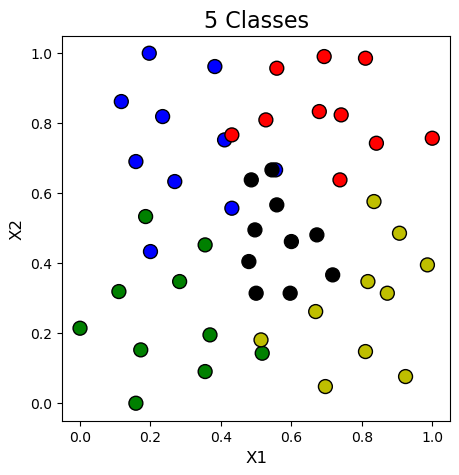

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
data_Class5 = np.loadtxt(readDataPath + '5class_data.csv',delimiter = ',')
df_Class5 = pd.DataFrame({'X1': data_Class5[0],'X2': data_Class5[1], 'Label': data_Class5[2]})
col_5C = np.where(df_Class5['Label']==0,'b',np.where(df_Class5['Label']==1,'r',np.where(df_Class5['Label']==2,'g', np.where(df_Class5['Label']==3, 'k', 'y'))))
ax.scatter(df_Class5['X1'],df_Class5['X2'],c= col_5C, s=100, edgecolors='k')
ax.set_title('5 Classes',fontsize=16)
ax.set_xlabel('X1', fontsize = 12)
ax.set_ylabel('X2', fontsize = 12)
plt.show()

In [58]:
num_runs = 3; max_its = 50000; alpha_choice = 10**(-2);
g = multiclass_softmax; 

In [59]:
x = data_Class5[0:-1]
y_labels = data_Class5[-1]
num_classes = len(np.unique(y_labels))

In [60]:
big_w_hist = [];
for j in range(num_runs):
    # create random initialization
    #np.random.seed(0)
    w_init =  np.random.randn(np.shape(x)[0]+1,num_classes)
    weight_history, cost_history = gradient_descent(g,alpha_choice,max_its,w_init, data = x, labels = y_labels, inputs_flag = True)
    #weight_history = gradient_descent_old(g,alpha_choice,max_its,w_init, data = x, labels = y_labels)  
    
    big_w_hist.append(weight_history)
    last_weights = weight_history[-1]
    #print(last_weights)
    #print(weight_history[-1])

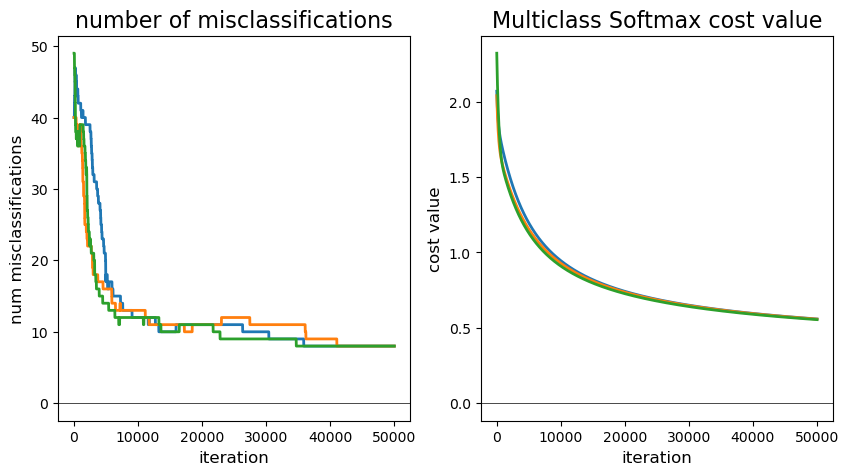

In [61]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(10, 5))
g_count = counting_cost
#### start runs and plotting ####
for j in range(num_runs):
    w_hist = big_w_hist[j]

    count_evals = []
    cost_evals = []
    for k in range(len(w_hist)):
        w = w_hist[k]
        g_eval = g(w,x,y_labels)
        cost_evals.append(g_eval)
        
        count_eval = g_count(w,x,y_labels)
        count_evals.append(count_eval)
    ax1.plot(np.arange(0,len(w_hist)),count_evals[:len(w_hist)],linewidth = 2)
    ax2.plot(np.arange(0,len(w_hist)),cost_evals[:len(w_hist)],linewidth = 2)
        
ax1.set_xlabel('iteration',fontsize = 12)
ax1.set_ylabel('num misclassifications',rotation = 90,fontsize = 12)
ax1.set_title('number of misclassifications',fontsize = 16)
ax1.axhline(y=0, color='k',zorder = 0,linewidth = 0.5)

ax2.set_xlabel('iteration',fontsize = 12)
ax2.set_ylabel('cost value',rotation = 90,fontsize = 12)
title = 'Multiclass Softmax cost value'
ax2.set_title(title,fontsize = 16)
ax2.axhline(y=0, color='k',zorder = 0,linewidth = 0.5)

plt.show()